In [1]:
#IMPORTS

import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
from scipy.stats import multivariate_normal 

%matplotlib inline

In [2]:
#LOADING THE VIDEO AND INITIALISING VARIABLES

vid=cv2.VideoCapture('umcp.mpg')
success, og = vid.read()
rows,cols,channels=og.shape
points=rows*cols

gray_frame = cv2.cvtColor(og, cv2.COLOR_BGR2GRAY) #Converting frame to grayscale for faster computation
K=3  #Number of gaussians per pixel

mean = np.zeros((points,K))
prior_prob =  np.zeros((points,K))
sigma=np.ones((points,K))


In [18]:
# DEFINING THE MATCH FUNCTION WITH MAHALANOBIS DISTANCE
def match(x,mu,sigma): 
    #x= pixel
    #sigma= covariance matrix, mu= mean matrix of each Gaussian
    diff=(x-mu)
    std=abs(np.sqrt(sigma)) #Standard deviation of the distribution
    d = float(np.abs(np.dot(diff.T,np.dot((np.linalg.inv(np.mat(sigma))),diff)))) #Mahalanobis distance calculation
    
    if d < (2.5*std): #Condition for matching the distribution

        return True
    else:
        return False

In [3]:
# K MEANS ON THE FIRST FRAME IN GRAYSCAlE

K=3 # Number of clusters
r = np.zeros((K,points)) # One hot encoding for each cluster
p = np.zeros(K) # Number of points in each cluster

u = np.array([40,130,255]) # Initial vaules of means
u_2 = np.array([40,130,255])

print("Initial value of u taken: \n", u)
itr=0
for numitr in range(10): # Computing till convergence or for maximum 10 iterations

    
    # EXPECTATION STEP: Minimise cost function wrt r_nk.
    # r_nk=1 for smallest distance between point n and centre k
    for i in range(rows):
        for j in range(cols):
            dist=[]
            x = gray_frame[i][j] #Pixel being tested
            
            for k in range(K):
                c = u[k] #Centre of the Kth cluster
                dist.append(np.sum((x - c) ** 2))
    
            d_min=np.argmin(np.array(dist))
            r[d_min][j + cols * i] = 1


    # MAXIMISATION STEP: Minimise cost function wrt u.
    # updating u as mean of the new clusters formed in expectation step    
    for k in range(K):
        u[k]=0
        p[k]=0
        for i in range(rows):
            for j in range(cols):
                u[k] = u[k] + gray_frame[i][j] * r[k][j + cols * i]
                p[k] = p[k] + r[k][j + cols * i]
        
        u[k] = u[k] / p[k]
    
    
    # Checking if the means are converged below a threshold
    sum = 0
    for k in range(K):
        sum = sum + np.sum((u_2[k] - u[k]) ** 2)
    if sum < 10:
        print("\n For iteration",itr+1,"\n Updated means of clusters is=\n",u)
        print("Number of points in each cluster is=",p)
        print("Difference in means from last iteration is=",sum,"\n Means converged, breaking loop...")
        break
    u_2=copy.deepcopy(u) 
    itr += 1
    print("\n For iteration",itr,"\n Updated means of clusters is= \n",u)
    print("Number of points in each cluster is=",p)


# Calculating the Variances of the new clusters around the means
si = np.zeros(K)
for k in range(K):
    for i in range(rows):
        for j in range(cols):
            x=gray_frame[i][j] 
            mu=u[k]
            delta=(x - mu)
            var=float(delta.T*delta)
            si[k] = si[k] + (var * r[k][j + cols * i])
            
    si[k] = si[k]/ (p[k]-1) # Sample mean formula


Initial value of u taken: 
 [ 40 130 255]

 For iteration 1 
 Updated means of clusters is= 
 [ 21 168 228]
Number of points in each cluster is= [37748. 43698.  3034.]

 For iteration 2 
 Updated means of clusters is=
 [ 23 168 228]
Number of points in each cluster is= [38699. 44027.  3034.]
Difference in means from last iteration is= 4 
 Means converged, breaking loop...


In [4]:
# Forming a new image to show the clustering result
k_out=np.zeros(gray_frame.shape,dtype=int)
   
for i in range(rows):
    for j in range(cols):
        for k in range(K):
                k_out[i][j] += u[k] * r[k][j + cols * i]

<Figure size 640x480 with 0 Axes>

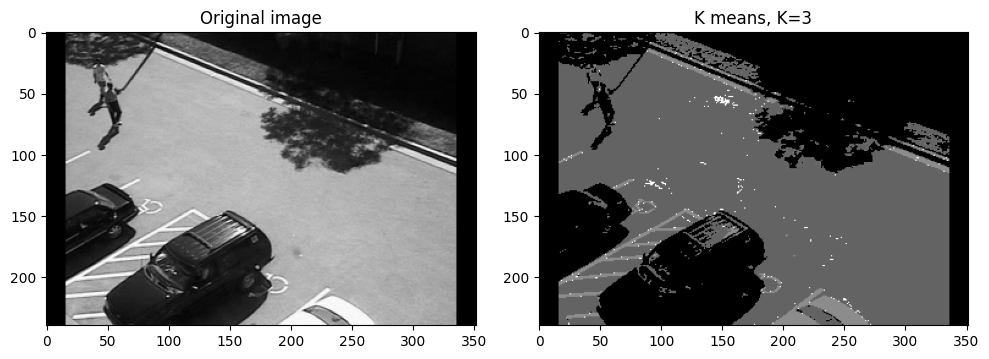

In [7]:
#K MEANS OUTPUT
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(gray_frame,cmap='grey')
ax[0].set_title("Original image")
ax[1].imshow(k_out,cmap='grey')
ax[1].set_title("K means, K=3")
fig.tight_layout()
plt.show()


In [26]:
# Making the K means output as Initialization for GMM
alpha=0.008
for k in range(K):
    for i in range(rows):
        for j in range(cols):
            mean[j + cols * i][k] = u[k]
            sigma[j + cols * i][k] =si[k]
            prior_prob[j + cols * i][k] = (1 / K) * (1 - alpha) + alpha * r[k][j + cols * i]


In [24]:
# CALCULATING FOREGROUND AND BACKGROUND PIXELS
def pixel_calculations(frame, mean,sigma, prior_prob):
    alpha = 0.008   # Learning rate
    K=3  # Number of Gaussians per pixel
    rows, cols = frame.shape
    # Initializing foreground and background frame
    back=np.zeros(og.shape,dtype=int)
    fore=np.zeros(og.shape,dtype=int)

    
    # Checking if pixel matches the existing K Gaussian distributions
    
    for i in range(rows):
        for j in range(cols):
            pixel=frame[i][j]
            n=j + cols * i
            flag = -1    # A flag with value -1 representing pixel not yet matched to any Gaussian 
            for k in range(K):
                
                if match(pixel, mean[n][k], sigma[n][k]):
                    
                    flag = k  # A flag with value k representing pixel being matched to Gaussian number k
                    ro= alpha * multivariate_normal.pdf(pixel, mean[n][k], sigma[n][k]) 
                    
                    # Updating means, variance and prior probabilities if pixel matched to a Gaussian
                    mean[n][k]= (1 - ro) * mean[n][k] + ro * pixel
                    delta=(x - mu)
                    var=float(np.dot(delta.T,delta))
                    sigma[n][k] = (1 - ro) * sigma[n][k] + (ro * (var))
                    prior_prob[n][k] = (1 - alpha) * prior_prob[n][k] + alpha
                    
                else:
                    # Updating prior_probs if pixel not matched to this Gaussian
                     prior_prob[n][k] = (1 - alpha) * prior_prob[n][k]
                        
    
                # Renormalizing the prior_probs
                sum_p=np.sum(prior_prob[n])
                prior_prob[n] /= sum_p
                                
                # Arranging Prior_prob, Means, Variances all in descending order of ratio of prior_prob/sigma
                ratio=np.zeros(K)
                ratio = np.array([prior_prob[n][k] / np.sqrt(sigma[n][k]) for k in range(K)])
                descending_order = np.argsort(-ratio)
                prior_prob[n]=prior_prob[n][descending_order]
                mean[n]=mean[n][descending_order]
                sigma[n]=sigma[n][descending_order]
                
                    
            
                # When None of the K distributions match the current value 
                # the least probable distribution is replaced with mean as current pixel, high variance value and low prior prob value
                if flag==-1:
                    mean[n][K-1] = pixel
                    sigma[n][K-1] = 1000
                    prior_prob[n][K-1]= 0.1
    
                # Calculating the most stable first 'B' Gaussians which correspond to the Background using threshold
                weight = 0
                B=0
                for k in range(K):
                     weight += prior_prob[n][k]
                     if weight > 0.5:
                          B = k+1
                          break

                # Forming Foreground and Background frames
                for k in range(B):
                     if flag==-1 or not(match(pixel, mean[n][k], sigma[n][k])): #Pixel not matching any, belongs to FG
                         fore[i][j]=og[i][j]      #Make FG image pixels= the frame pixels
                         back[i][j]=[128,128,128] #Make BG image pixels= grey for these pixels
                         break
                     else: #Pixel match one of them, belongs to BG
                         back[i][j]=og[i][j]      #Make BG image pixels= the frame pixels
                         fore[i][j]=[255,255,255] #Make FG image pixels= white for these pixels
    return back,fore

In [27]:
count=0

# Running for each frame of the video and saving FG and BG frames
while (success):
            
    # take each frame from the video
    success, og = vid.read()
    gray_frame = cv2.cvtColor(og, cv2.COLOR_BGR2GRAY)
    
    back, fore = pixel_calculations(gray_frame, mean, sigma, prior_prob)
    print("Saving frame ",count+1)
    
    # save the foreground and background frames
    cv2.imwrite("D:/BG sub/GMM/Fore/F"+ str(count)+".jpg", fore)
    cv2.imwrite("D:/BG sub/GMM/Back/B"+ str(count)+".jpg", back)

    count += 1

Saving frame  1
Saving frame  2
Saving frame  3
Saving frame  4
Saving frame  5
Saving frame  6
Saving frame  7
Saving frame  8
Saving frame  9
Saving frame  10
Saving frame  11
Saving frame  12
Saving frame  13
Saving frame  14
Saving frame  15
Saving frame  16
Saving frame  17
Saving frame  18
Saving frame  19
Saving frame  20
Saving frame  21
Saving frame  22
Saving frame  23
Saving frame  24
Saving frame  25
Saving frame  26
Saving frame  27
Saving frame  28
Saving frame  29
Saving frame  30
Saving frame  31
Saving frame  32
Saving frame  33
Saving frame  34
Saving frame  35
Saving frame  36
Saving frame  37
Saving frame  38
Saving frame  39
Saving frame  40
Saving frame  41
Saving frame  42
Saving frame  43
Saving frame  44
Saving frame  45
Saving frame  46
Saving frame  47
Saving frame  48
Saving frame  49
Saving frame  50
Saving frame  51
Saving frame  52
Saving frame  53
Saving frame  54
Saving frame  55
Saving frame  56
Saving frame  57
Saving frame  58
Saving frame  59
Saving

KeyboardInterrupt: 

In [ ]:
#Making Background Video from the generated frames 

# Initialize variable to write the video at 30FPS
out = cv2.VideoWriter("D:/BG sub/GMM/Back.avi", cv2.VideoWriter_fourcc(*'DIVX'), 30.0, (cols,rows))
count = 0

# Write the frames into the video
while (count < total):
    # Read the frame
    frame = cv2.imread("D:/BG sub/GMM/Back/B"+str(count)+".jpg",1)
    # Write the frame in to the video
    out.write(frame)
    count += 1
out.release()



In [ ]:
#Making Foreground Video from the generated frames 

# Initialize variable to write the video at 30FPS
out = cv2.VideoWriter("D:/BG sub/GMM/Fore.avi", cv2.VideoWriter_fourcc(*'DIVX'), 30.0, (cols,rows))
count = 0

# Write the frames into the video
while (count < total):
    # Read the frame
    frame = cv2.imread("D:/BG sub/GMM/Fore/F"+str(count)+".jpg",1)
    # Write the frame in to the video
    out.write(frame)
    count += 1
out.release()

